In [99]:
%ls -rlth

total 2.3G
-rw-r--r-- 1 dueo dueo 2.3G Jul 28 20:17 HCS_48x48.npz
-rw-r--r-- 1 dueo dueo 965K Jul 29 11:16 DataHandling.ipynb
-rw-r--r-- 1 dueo dueo  229 Jul 29 11:55 README.md
-rw-r--r-- 1 dueo dueo 934K Jul 29 20:32 FirstNetwork_dummy.ipynb
-rw-r--r-- 1 dueo dueo 928K Jul 29 20:41 FirstNetwork.ipynb
-rw-r--r-- 1 dueo dueo 2.6M Jul 29 20:43 net_aug_epoch42_91prec.pickle


In [4]:
import skimage
skimage.__version__ # We need at least version 0.11.3

'0.11.3'

In [5]:
import gzip
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
%matplotlib inline

In [6]:
start = time.time()
#with open('HCS_48x48.npz') as f:
npzfile = np.load('HCS_48x48.npz')
print ("Loaded data in " + str(time.time() - start))

Loaded data in 0.000756978988647


In [7]:
npzfile.files

['arr_1', 'arr_0', 'arr_2']

In [8]:
start = time.time()
cell_rows = npzfile['arr_0']
X = npzfile['arr_1']
Y = npzfile['arr_2']
print ("Loaded data in " + str(time.time() - start))

Loaded data in 4.50605797768


In [9]:
np.shape(cell_rows), np.shape(Y), np.shape(X), type(X)

((52950,), (52950,), (52950, 5, 48, 48), numpy.ndarray)

(-0.5, 3.5)

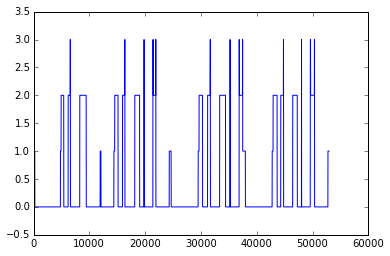

In [10]:
plt.plot(Y)
plt.ylim(-0.5,3.5)

### Normalization

In [11]:
Xmean = X.mean(axis = 0)
XStd = np.sqrt(X.var(axis=0))
X = (X-Xmean)/(XStd + 0.01)

In [12]:
np.min(X), np.max(X), np.mean(X)

(-2.5230029, 55.53228, 1.3684561e-07)

In [13]:
Y = np.asarray(Y,dtype='int32')

### Some examples (after normalization)
rows are the different compounds

Populating the interactive namespace from numpy and matplotlib
Average values -0.223322480917, -0.844869852066, -0.98758995533, -0.243704929948


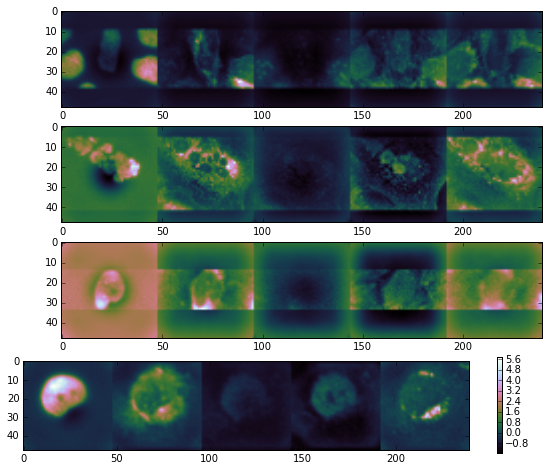

In [14]:
%pylab inline
cmap = plt.get_cmap('cubehelix')
pylab.rcParams['figure.figsize'] = (10.0, 10.0)
idx = (np.argwhere(Y == 0)[0][0], 
       np.argwhere(Y == 1)[0][0], 
       np.argwhere(Y == 2)[0][0], 
       np.argwhere(Y == 3)[0][0])
cmap = plt.get_cmap('cubehelix')
plt.subplot(511) 
plt.imshow(np.concatenate(X[idx[0],:,:,:],axis=1), cmap=plt.get_cmap('cubehelix'))
plt.subplot(512) 
plt.imshow(np.concatenate(X[idx[1],:,:,:],axis=1), cmap=plt.get_cmap('cubehelix'))
plt.subplot(513) 
plt.imshow(np.concatenate(X[idx[2],:,:,:],axis=1), cmap=plt.get_cmap('cubehelix'))
plt.subplot(514) 
plt.imshow(np.concatenate(X[idx[3],:,:,:],axis=1), cmap=plt.get_cmap('cubehelix'))
print('Average values {0}, {1}, {2}, {3}'.format(np.mean(X[idx[0],:,:,:]),np.mean(X[idx[1],:,:,:]),np.mean(X[idx[2],:,:,:]),np.mean(X[idx[3],:,:,:])))
plt.colorbar()
plt.show()

### Splitting in training and test-set

#### Version 1
We take all, which is  below 40000 for training and validation and images above for testing.

In [200]:
# Currently a Acc. of 0.8250
split = 40000
X_train = X[0:split,:,:,:]
Y_train = Y[0:split]
X_test = X[split:,:,:,:]
Y_test = Y[split:]

#### Version 2
80%, 20% randomly choosen

In [15]:
# Currently a Acc. of 0.8976
perm1 = np.random.permutation(len(Y))
N_split = int(len(Y) * 0.8)
N_split
idx_train  = perm1[:N_split]
idx_test  = perm1[N_split:]
    

X_train = X[idx_train,:,:,:]
Y_train = Y[idx_train]
X_test = X[idx_test,:,:,:]
Y_test = Y[idx_test]

#### Permuting the training set

In [16]:
perm = np.random.permutation(len(Y_train))
XX = X_train[perm,:,:,:]
YY = Y_train[perm]

In [134]:
PIXELS = 48

from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

net1 = NeuralNet(
    # Geometry of the network
    layers=[
        ('input', layers.InputLayer),
        
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        
        ('hidden3', layers.DenseLayer),
        ('dropout3', layers.DropoutLayer),
        
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 5, PIXELS, PIXELS), #None in the first axis indicates that the batch size can be set later
    conv1_num_filters=32, conv1_filter_size=(5, 5), pool1_pool_size=(2, 2), #pool_size used to be called ds in old versions of lasagne
    dropout1_p=0.0,
    
    conv2_num_filters=64, conv2_filter_size=(3, 3), pool2_pool_size=(2, 2),
    dropout2_p=0.3,
    
    hidden3_num_units=100,
    dropout3_p=0.3,
    
    hidden4_num_units=20,
    dropout4_p=0.3,
    
    output_num_units=5, output_nonlinearity=nonlinearities.softmax,

    # learning rate parameters
    update_learning_rate=0.01,
    update_momentum=0.9,
    regression=False,
    # We only train for 10 epochs
    max_epochs=20,
    verbose=1,

    # Training test-set split
    eval_size = 0.2
    )

In [215]:
net = net1.fit(XX,YY)

# Neural Network with 664753 learnable parameters

## Layer information

|   # | name     | size     |
|----:|:---------|:---------|
|   0 | input    | 5x48x48  |
|   1 | conv1    | 32x44x44 |
|   2 | pool1    | 32x22x22 |
|   3 | dropout1 | 32x22x22 |
|   4 | conv2    | 64x20x20 |
|   5 | pool2    | 64x10x10 |
|   6 | dropout2 | 64x10x10 |
|   7 | hidden3  | 100      |
|   8 | dropout3 | 100      |
|   9 | hidden4  | 20       |
|  10 | dropout4 | 20       |
|  11 | output   | 5        |

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       0.58012       0.46412      1.24994      0.82507  14.03s
      2       0.45603       0.39542      1.15328      0.85766  13.94s
      3       0.40363       0.36415      1.10843      0.86847  13.94s
      4       0.37679       0.33958      1.10957      0.87325  13.94s
      5       0.35524       0.35780      0.99285      0.87360  13.94s
      6       0.337

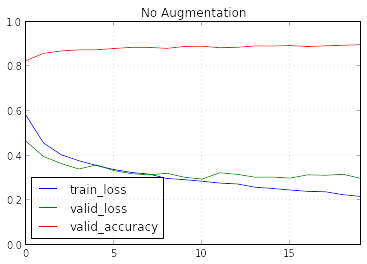

In [216]:
%matplotlib inline
import pandas as pd
dfNoAug = pd.DataFrame(net.train_history_)
dfNoAug[['train_loss','valid_loss','valid_accuracy']].plot(title='No Augmentation', ylim=(0,1))

We see a overfitting after approx 20 Epochs.

In [217]:
pred = net.predict(X_test)

In [218]:
sum(pred == Y_test)/float(len(Y_test))

0.89763928234183188

### Calucation of the confusion matrix

In [219]:
from sklearn.metrics import confusion_matrix
import pandas as pd
names = ('DMSO True', 'PACLITAXEL True', 'METOCLOPRAMIDE True', 'DIGOXIN True')
m = confusion_matrix(pred, Y_test)
df = pd.DataFrame(m)
df.columns = names
names = ('DMSO Pred', 'PACLITAXEL Pred', 'METOCLOPRAMIDE Pred', 'DIGOXIN Pred')
df.index = names
df

,DMSO True,PACLITAXEL True,METOCLOPRAMIDE True,DIGOXIN True
DMSO Pred,7877,67,625,0
PACLITAXEL Pred,63,300,60,2
METOCLOPRAMIDE Pred,226,37,1248,0
DIGOXIN Pred,0,3,1,81


In [220]:
np.sum(Y_test==0)

8166

# Using data augmentation
Rotations are a bit tricky in skimage ...

-10.0 15.5 -9.98975055173 15.4856895176 


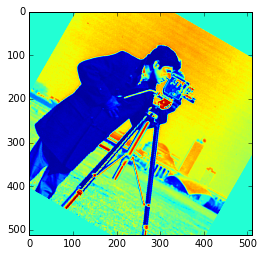

In [62]:
from skimage import data
from skimage import transform as tf
image = np.asarray(data.camera())/10.0 - 10.0

# See http://stackoverflow.com/questions/25895587/python-skimage-transform-affinetransform-rotation-center
tf_rotate = tf.SimilarityTransform(rotation=np.deg2rad(30))
shift_y, shift_x = np.array(image.shape[:2]) / 2.
tf_shift = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
tf_shift_inv = tf.SimilarityTransform(translation=[shift_x, shift_y])
tform = (tf_shift + (tf_rotate + tf_shift_inv)).inverse 


#tform = tf.SimilarityTransform(scale=1.01, rotation=np.pi/8, translation=(10, 2))
dd = tf.warp(image, tform, preserve_range = True)
plt.imshow(dd)
print('{0} {1} {2} {3} '.format(np.min(image), np.max(image), np.min(dd), np.max(dd)))


In [70]:
tf_shift_inv + tf_shift_inv.inverse + tf.SimilarityTransform(scale=np.random.uniform(0.9,1.10))

In [138]:
rots = np.deg2rad(range(0,359))
rots[12]

0.20943951023931956

before -0.710339188576 after -0.577832639217
before -0.576782107353 after -0.485753595829
before -0.558508038521 after -0.422648072243
before -0.376092225313 after -0.264546006918
before -0.282508045435 after -0.204075574875
before 0.322340279818 after 0.377392828465
before -0.414854556322 after -0.309473097324
before 0.381428569555 after 0.380622595549
before 0.325613856316 after 0.346425533295
before -0.485596030951 after -0.443012624979
before -0.267797380686 after -0.252701640129
before -0.028503537178 after -0.0132785504684
before 1.06008517742 after 0.960695683956
before 0.0770552232862 after 0.115017980337
before -0.455671042204 after -0.384281307459
before 0.975390970707 after 0.917320251465
before -0.134527564049 after -0.0658261477947
before 0.320359557867 after 0.338999450207


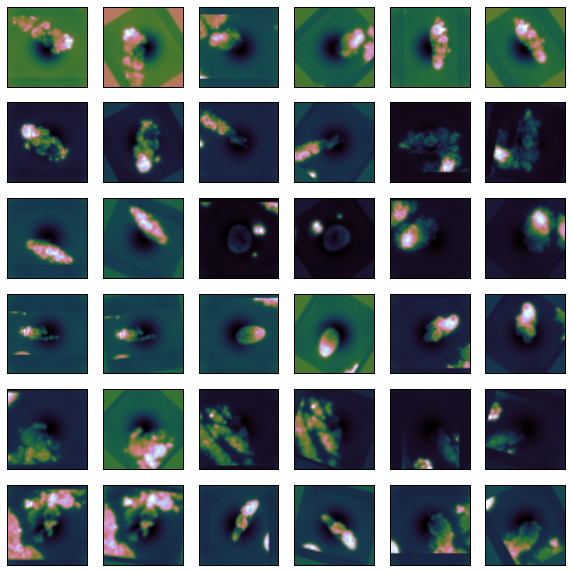

In [139]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import numpy as np
from skimage import transform as tf

#rots = np.deg2rad(np.asarray((90,180,0,5,-5,10,-10)))
rots = np.deg2rad(range(0,359))

dists = (-5,5)

def manipulateTrainingData(Xb):
    retX = np.zeros((Xb.shape[0], Xb.shape[1], Xb.shape[2], Xb.shape[3]), dtype='float32')
    for i in range(len(Xb)):
        rot = rots[np.random.randint(0, len(rots))]
        
        tf_rotate = tf.SimilarityTransform(rotation=rot)
        shift_y, shift_x = np.array((X.shape[2], X.shape[3])) / 2.
        tf_shift = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
        tf_shift_inv = tf.SimilarityTransform(translation=[shift_x, shift_y])
        tform_rot = (tf_shift + (tf_rotate + tf_shift_inv)).inverse 
        
        ## TODO add the transformations
        #dist = dists[np.random.randint(0, len(dists))]
        scale = np.random.uniform(0.9,1.10)
        d = tf.SimilarityTransform(scale=scale)
        tform_other = tform_rot 
        
        for c in range(np.shape(X)[1]):
            maxAbs = 256.0;np.max(np.abs(Xb[i,c,:,:]))
            # Needs at lease 0.11.3
            retX[i,c,:,:] = tf.warp(Xb[i,c,:,:], tform_other, preserve_range = True) # "Float Images" are only allowed to have values between -1 and 1        
    return retX


Xb = np.copy(X[0:100,:,:,:])
Xb = manipulateTrainingData(Xb)

fig = plt.figure(figsize=(10,10))
for i in range(18):
    a=fig.add_subplot(6,6,2*i+1,xticks=[], yticks=[])
    plt.imshow(X[i,0,:,:], cmap=plt.get_cmap('cubehelix'))
    a=fig.add_subplot(6,6,2*i+2,xticks=[], yticks=[])
    plt.imshow(Xb[i,0,:,:], cmap=plt.get_cmap('cubehelix'))
    print('before {0} after {1}'.format(np.mean(X[i,1,:,:]), np.mean(Xb[i,1,:,:])))

In [ ]:
from nolearn.lasagne import BatchIterator

class SimpleBatchIterator(BatchIterator):

    def transform(self, Xb, yb):
        Xb, yb = super(SimpleBatchIterator, self).transform(Xb, yb)
        #return Xb[:,:,:,::-1], yb #<--- Here we do the flipping of the images
        return manipulateTrainingData(Xb), yb
    
# Setting the new batch iterator
net1Aug = net1
net1Aug.max_epochs = 400
net1Aug.batch_iterator_train = SimpleBatchIterator(256)
netAug = net1Aug.fit(XX, YY)

# Neural Network with 664753 learnable parameters

## Layer information

|   # | name     | size     |
|----:|:---------|:---------|
|   0 | input    | 5x48x48  |
|   1 | conv1    | 32x44x44 |
|   2 | pool1    | 32x22x22 |
|   3 | dropout1 | 32x22x22 |
|   4 | conv2    | 64x20x20 |
|   5 | pool2    | 64x10x10 |
|   6 | dropout2 | 64x10x10 |
|   7 | hidden3  | 100      |
|   8 | dropout3 | 100      |
|   9 | hidden4  | 20       |
|  10 | dropout4 | 20       |
|  11 | output   | 5        |

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       0.68368       0.54163      1.26225      0.76973  52.09s

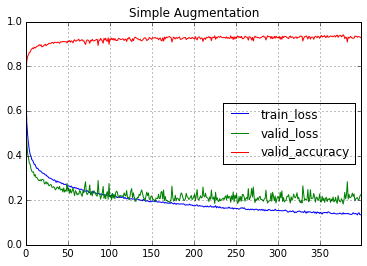

In [141]:
%matplotlib inline
import pandas as pd
dfAug = pd.DataFrame(net1Aug.train_history_)
dfAug[['train_loss','valid_loss','valid_accuracy']].plot(title='Simple Augmentation', ylim=(0,1))

In [143]:
pred = netAug.predict(X_test)

In [144]:
sum(pred == Y_test)/float(len(Y_test))#0.8986779981114259, 0.9244570349386213

0.92237960339943348

In [145]:
import cPickle as pickle
with open('net_aug_epoch400_all_rot_92prec.pickle', 'wb') as f:
    pickle.dump(netAug, f, -1)

In [146]:
from sklearn.metrics import confusion_matrix
import pandas as pd
names = ('DMSO True', 'PACLITAXEL True', 'METOCLOPRAMIDE True', 'DIGOXIN True')
m = confusion_matrix(pred, Y_test)
df = pd.DataFrame(m)
df.columns = names
names = ('DMSO Pred', 'PACLITAXEL Pred', 'METOCLOPRAMIDE Pred', 'DIGOXIN Pred')
df.index = names
df

,DMSO True,PACLITAXEL True,METOCLOPRAMIDE True,DIGOXIN True
DMSO Pred,7777,13,292,2
PACLITAXEL Pred,73,365,21,3
METOCLOPRAMIDE Pred,402,16,1544,0
DIGOXIN Pred,0,0,0,82


### Normalizing the confusion matrix
See http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [133]:
cm_normalized = m.astype('float') / m.sum(axis=0)[:, np.newaxis]
print('Normalized confusion matrix')
pd.DataFrame(cm_normalized)

Normalized confusion matrix


,0,1,2,3
0,0.964736,0.003151,0.053078,0.000000
1,0.104061,0.865482,0.043147,0.002538
2,0.134087,0.014001,0.754981,0.000000
3,0.011494,0.011494,0.000000,0.988506


In [130]:
np.mean(cm_normalized[diag_indices(4)])

0.89342623866107862